## 12-14. 프로젝트: CIFA-10 이미지 생성하기
---------------------------------------------------------------------------------------------------
이미지 shape이 28, 28, 1 -> 32, 32, 3
이미지가 흑백->RGB 3채널
입력데이터 차원이 3~4배 증가

In [1]:
# $ pip install imageio
# $ pip install Pillow

# $ mkdir -p ~/aiffel/dcgan_newimage/fashion/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/fashion/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/fashion/training_history
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


### step1. 데이터셋 구성하기
---------------------------------------------------------------------------------------------------
학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.  
로드한 학습 데이터를 시각화를 통해 확인해 봅시다.  
tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

#각 픽셀마다 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

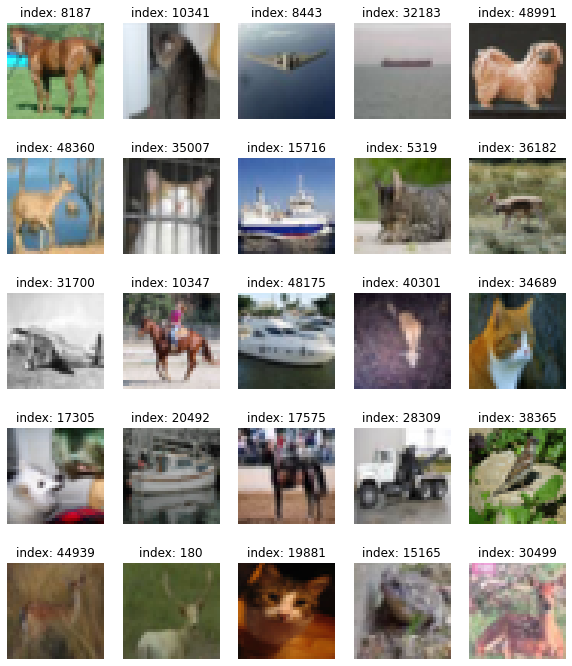

In [3]:
#25개 임의로 불러오기
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [4]:
#버퍼사이즈는 전체를 섞기위해 전체 크기로 설정. shuffle()함수 이용.
#미니배치 학습에 사용할 배치사이즈 256
BUFFER_SIZE = 60000
BATCH_SIZE = 512#고양이가 512, epoch 200정도

In [5]:
#train_x라는 numpy ndarray 자료를 섞고 배치사이즈에 따라 나눈다. 데이터가 잘 섞이려면 버퍼사이즈가 총 데이터 사이즈와 같거나 커야 한다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### step2. 생성자 모델 구현하기
---------------------------------------------------------------------------------------------------
(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [30]:
def make_generator_model():#drop out 추가했음

    # Start, 모델 시작
    model = tf.keras.Sequential()# 입력값으로 (batch size, 100)모양의 노이즈 벡터

    # First: Dense layer
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))# (batch size, 8*8*768)모양의 벡터가 됨.
    model.add(layers.BatchNormalization())#신경망 가중치 폭발방지를 위한 가중치 값 정규화
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 512)))#1차원 벡터를 (8, 8, 768)모양의 3차원 벡터로 변환
    #현재 모든 덴스 2배로 바꾼것
    # Third: Conv2DTranspose layer, 이미지의 크기를 넓혀주는 층. 
    model.add(layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())#
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))# -1 ~ 1 값을 픽셀값으로 정규화했던 데이터셋과 동일하게 하기 위해서!
    
    return model

In [31]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32768)             3276800   
_________________________________________________________________
batch_normalization_3 (Batch (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 256)         2097152   
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 256)        

In [32]:
# 랜덤 벡터로 이루어진 노이즈벡터 생성
noise = tf.random.normal([1, 100])

In [33]:
generated_image = generator(noise, training=False)
generated_image.shape
#앞의 1은 배치사이즈로 뒤의 28,28,1사이즈 이미지 생성

TensorShape([1, 32, 32, 3])

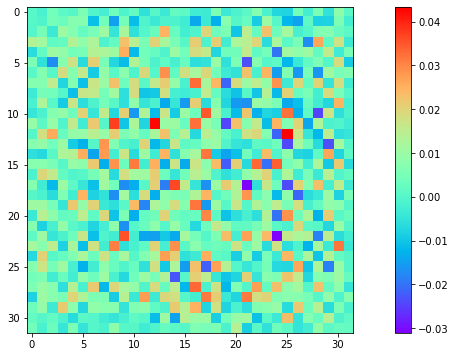

In [34]:
#만든 이미지 시각화, 2차원 이미지만 보여줄 수 있으므로 0, 3번 인덱스값을 0으로 설정
plt.imshow(generated_image[0, :, :, 0], cmap='rainbow')
plt.colorbar()
plt.show()

### step3. 판별자 모델 구현하기
---------------------------------------------------------------------------------------------------
(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [52]:
def make_discriminator_model():#drop out원래 있는데 일단 생략

    # Start
    model = tf.keras.Sequential()
    #이미지 크기를 점점 줄여나간다.(28, 28, 1) -> (14, 14, 64) -> (7, 7, 128)
    # First: Conv2D Layer
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.2))

    
    # Third: Flatten Layer (7,7,128) -> (1, 7*7*128)으로 변환
    model.add(layers.Flatten())

    # Fourth: Dense Layer 하나의 값만 출력
    model.add(layers.Dense(1, activation='sigmoid'))#이부분바꿨다. activation 추가

    return model

In [53]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 256)       12544     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 256)         1048832   
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)            

In [54]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49999356]], dtype=float32)>

### step4. 손실함수와 최적화함수 구현하기
---------------------------------------------------------------------------------------------------
생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [55]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)# from_logits=True를 이용해 sigmoid로 정규화

In [56]:
def generator_loss(fake_output): #생성자 손실함수
    return cross_entropy(tf.ones_like(fake_output), fake_output) # fake_output이 1에 가까울수록 작은 값을 출력

In [57]:
def discriminator_loss(real_output, fake_output): #판별자 손실함수
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)#1로만 이루어진 벡터와
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)#0으로만 이루어진 벡터와
    total_loss = real_loss + fake_loss
    return total_loss

In [58]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy
#너무 잘 판별하면(fake_accuracy가 1.0에 가까우면) 생성자가 판별자를 속이지 못하는 것이므로 안좋다.
#가장 좋은 것은 fake_accuracy, real_accuracy가 초반에는 1.0에 가깝게 나오다가 나중에는 0.5에 가까워지는 것이 이상적
#예시 real_output이 tf.Tensor([0.2, 0.4, 0.7, 0.9])면
#tf.math.greater_equal(real_output, tf.constant([0.5]) 에서 0.5를 기준으로 True, False로 변환
#tf.cast(~~, tf.float32)에서 True면 1.0, False면 0.0으로 변환
#tf.reduce_mean(~~, tf.float32)은 입력값을 평균내어 정확도 계산

In [59]:
#Adam 최적화 기법 각각 최적화함수 따로 만듬
generator_optimizer = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.5)

In [60]:
#샘플을 한번에 16장씩 생성. 100차원 노이즈를 16개. (16, 100)
#시드 노이즈를 정해야 진전여부를 파악가능
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### step5. 훈련과정 상세기능 구현하기
---------------------------------------------------------------------------------------------------
1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [61]:
@tf.function
def train_step(images):  #(1) 입력데이터 real image 역할을 할 images 한세트(batch size) 입력받음
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 가짜 이미지를 만들기 위해서 생성자에 넣을 노이즈(batch size)만큼 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈 gradient 자동 미분 계산
        generated_images = generator(noise, training=True)  #(4) generated_images 생성(가짜이미지)

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [62]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False) # sample_seeds에 16개 seed 들어있다.

    fig = plt.figure(figsize=(4, 4))# 16개의 샘플 시각화
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] +1)/2.0)#prediction은 -1~1이므로 +1을 하고 /2하면 0~1분포로 바뀜
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/new_sample_epoch_{:04d}_iter_{:03d}.png'#생성한 이미지 저장
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [63]:
#gen_loss, disc_loss, real_accuracy, fake_accuracy 시각화.
#생성자와 판별자가 서로의 학습과정에 영향을 줘서 학습과정을 체크하기 위해서 매 epoch마다 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

#모델 저장을 위한 checkpoint만들기(생성자와 구분자가 학습한 모델 가중치 저장)
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "new_ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [64]:
# 정기적으로 모델을 저장하기 위한 checkpoint를 만들어준다
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### step6. 학습과정 진행하기
---------------------------------------------------------------------------------------------------
위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.
(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [65]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [66]:
# 모델 저장 간격 save_every, 전체 학습 에포크 EPOCHS 설정후 훈련
save_every = 5
EPOCHS = 150

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

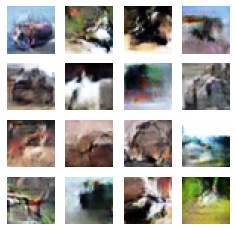

Time for training : 4988 sec


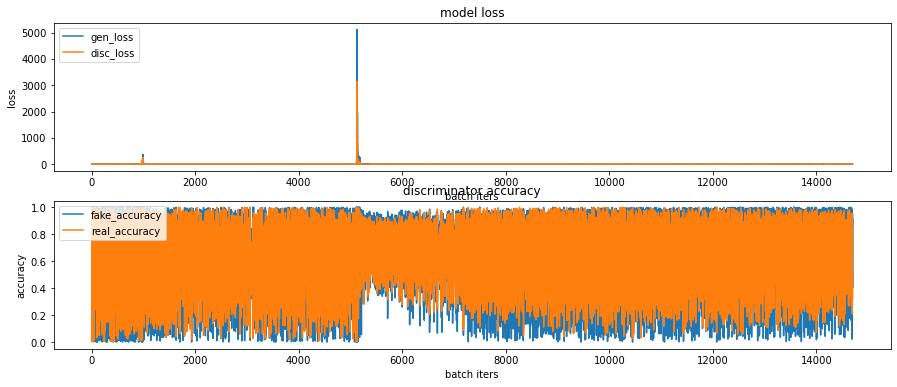

CPU times: user 1h 22min 27s, sys: 1min 14s, total: 1h 23min 42s
Wall time: 1h 23min 9s


In [67]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [68]:
#생성했던 이미지들로 GIF를 만들어 진행과정 확인
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/new_image_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/new_sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 ssac19 ssac19 1270318  2월 24 22:58 /home/ssac19/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


discriminator model의 마지막에 sigmoid를 넣어서 fake_output을 0~1로 정규화해 결과값을 정돈하고, binarycrossentropy에서 logits을 False로 만들어서 sigmoid로 정규화하지 않았습니다.  
정규화시에 계산한 결과 중에 날라가는 것이 있을 것으로 생각해서 삭제했습니다.  
deepml강의에서 들었던 것을 기억하여 batch_size를 하드웨어가 버티는 선으로 크기를 키웠습니다.  
discriminator에서 dense의 값을 늘려서 학습할 양을 늘렸습니다.  
또한 LeakyReLu에서 alpha값은 0.2로 잡아서 음수부분의 값을 좀더 보존하는 식으로 바꿨습니다.